# A glimpse of ChoCo

In [1]:
%load_ext autoreload
%autoreload 2

### Notes on the format of statistics in this notebook

- **Duration**, per score and audio, distplot for each (+ mu and std in text)
- **Type**: proportion of score/audio can be mentioned in text, or table.

- **Identifiers**, mentioned in text -- number, proportion and counts.
- **Composers** and **performers**  -- number, proportion, and counts.
- **No. of annotations** (in total), just mention in text.

#### Per annotation namespace (e.g. key, chord in Harte)

- Annotation type: count, not interesting if separated because many keys-chords would follow the same (can avoid).
- **Annotators**, same as before, mention for how many this is available, possibly mention the top 3.

- **No. of observations** (and **unique**): distplot + reference to mean and std
    - For keys, we can filter out the global, and report for when more are given (to avoid inflating 1s).
- **Observation occurrences** (and **w/o reps**), plot histograms of count with relative freqs as plot annotation.

- **N-grams**, same as before. Maybe use table if this is cluttered by labels.

- Durations of observations, per audio and score separately, distplot of averages.

PS: Some of these annotation statistics may make sense only for chords, and not for keys. We can choose a subset of them for keys.

In [2]:
import os
import sys
import glob
import joblib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown as md

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "choco"))

from jams_stats import ChoCoAnnotationStats, ChoCoDatasetStats, StatsExtractorState
from utils import stringify_dict

# Choose plotting style
sns.set_style("whitegrid")
sns.set_style("darkgrid")

In [3]:
from collections import Counter

def plot_counter(cnt:Counter, name:str, horizontal=False, show_pcts=True,
    first_n=100, title="", ax=None, figsize=(10, 4)):

    fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)

    truncated_cnt = cnt.most_common()[:first_n]
    count_df = pd.DataFrame(truncated_cnt, columns=[name, "count"])
    pcts = round(count_df["count"] / sum(cnt.values()), 2)

    x, y = (name, "count") if not horizontal else ("count", name)
    ax = sns.barplot(x=x, y=y, data=count_df, ax=ax)

    if show_pcts:  # plot percentages as relative counts
        ax.bar_label(ax.containers[0], pcts, label_type='center')
    ax.set_title(title)
    
    return ax


def plot_histogram(values:list, unit:str, title="", ax=None, figsize=(10, 4)):
    
    fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)
    sns.histplot(values, kde=True, ax=ax)

    ax.set_xlabel(unit)
    ax.set_title(title)

    return ax


def create_ngram_df(ngram_cnt:Counter, name:str, first_n=10):

    ngram_records = ngram_cnt.most_common(first_n)  # get ngram tuples
    ngram_df = []  # holding ngram dictionaries, incrementally
    for ngram_record in ngram_records:
        ngram, cnt = ngram_record
        ngram_df.append({**{f"{name}_{i+1}": c for i, c in enumerate(ngram)},
                         **{"cnt": cnt}})  # append actual ngram count

    ngram_df = pd.DataFrame(ngram_df)
    return ngram_df

In [4]:
jams_stats_file = "../partitions/isophonics/choco/jams_stats.joblib"
dataset_stats_file = "../partitions/isophonics/choco/dataset_stats.joblib"

In [5]:
with open(jams_stats_file, 'rb') as jobfile:
    jams_stats = joblib.load(jobfile)

with open(dataset_stats_file, 'rb') as jobfile:
    data_stats = joblib.load(jobfile)

print(f"{len(jams_stats)} JAMS stats")

225 JAMS stats


## Meta-stats

In [6]:
no_jams, no_annotations = data_stats.no_processed_elements
annotation_stats = data_stats._annotation_stats_ext

In [7]:
annotations_per_namespace = [f"{extractor.no_processed_elements} {name} annotations" for name, extractor in annotation_stats.items()]

md(f"The dataset contains {no_jams} JAMS files: {len(data_stats._durations['audio']['values'])} audio JAMS and {len(data_stats._durations['score']['values'])} score JAMS.\n"
f"In these ChoCo JAMS files, {no_annotations} different annotations were found: {', '.join(annotations_per_namespace)}.")

The dataset contains 225 JAMS files: 225 audio JAMS and 0 score JAMS.
In these ChoCo JAMS files, 871 different annotations were found: 225 chord annotations, 224 key_mode annotations, 225 segment_open annotations, 197 beat annotations.

#### Identifiers

In [8]:
md(f"In total, {data_stats._identifiers['sum']} identifiers were found, which cover {data_stats._identifiers['proportion']}% of the dataset.")

In total, 0 identifiers were found, which cover 0.0% of the dataset.

In [9]:
if data_stats._identifiers['sum'] > 0:
    plot_counter(data_stats._identifiers['cnt'], "resources")

#### Durations

In [10]:
md(f"The average duration of audio pieces is {data_stats._durations['audio']['mean']} ± {data_stats._durations['audio']['std']} seconds.\n That of score, instead, is {data_stats._durations['score']['mean']} ± {data_stats._durations['score']['std']} measures.")

# data_stats._durations["audio"]["values"]

The average duration of audio pieces is 172.77904 ± 59.79496937467567 seconds.
 That of score, instead, is None ± None measures.

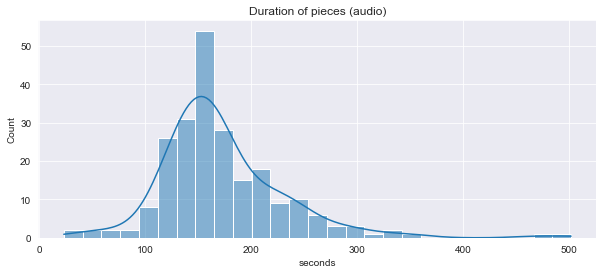

In [11]:
if data_stats._durations['audio']['values'] != []:
    plot_histogram(data_stats._durations['audio']['values'],
        "seconds", title="Duration of pieces (audio)")

In [12]:
if data_stats._durations['score']['values'] != []:
    plot_histogram(data_stats._durations['score']['values'],
        "measures", title="Duration of pieces (score)")

#### Composers and performers

In [13]:
md(f"In the enriched metadata, {data_stats._performers['sum']} performers were found in the JAMS, which covers {data_stats._performers['proportion']}% of the whole dataset. Analogously, a total of  {data_stats._composers['sum']} composers were found ({data_stats._composers['proportion']}% coverage).")

In the enriched metadata, 225 performers were found in the JAMS, which covers 1.0% of the whole dataset. Analogously, a total of  0 composers were found (0.0% coverage).

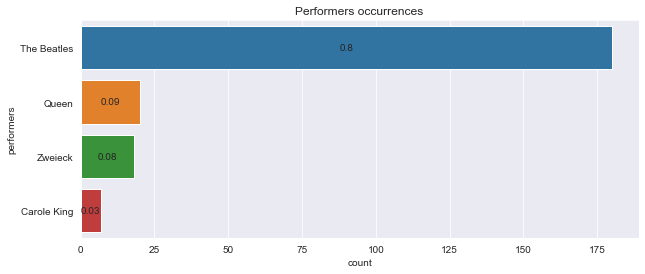

In [14]:
if data_stats._performers['sum'] > 0:
    plot_counter(data_stats._performers["cnt"], "performers", first_n=10,
                title="Performers occurrences", horizontal=True)

In [15]:
if data_stats._composers['sum'] > 0:
    plot_counter(data_stats._composers["cnt"], "composers", first_n=10,
                title="Composers occurrences", horizontal=True)

## Content-stats


In [16]:
print(f"Choose one of these: {list(annotation_stats.keys())}")

NAMESPACE = "chord"
DESCRIPTION = "chords"

Choose one of these: ['chord', 'key_mode', 'segment_open', 'beat']


In [17]:
annotation_stats = data_stats._annotation_stats_ext[NAMESPACE]

#### Annotators and annotation types

In [18]:
annotation_stats._annotation_type

Counter({'expert_human': 225})

In [19]:
all_annotators =  sum(annotation_stats._annotators['cnt'].values())
real_annotators = sum([c for name, c \
    in annotation_stats._annotators['cnt'].items() if name != "Unknown"])

md(f"Number of annotators for which their identity is known: {real_annotators}, covering {annotation_stats._annotators['proportion']}% of {NAMESPACE} annotations.")

Number of annotators for which their identity is known: 0, covering 0.0% of chord annotations.

In [20]:
if real_annotators > 0:
    plot_counter(annotation_stats._annotators['cnt'], "annotator names", first_n=10,
                title="Annotators: top contributors", horizontal=True)

#### Observation occurrences

In [21]:
total_occurrences = sum(annotation_stats._no_observations["values"])
total_occurrences_uniq = sum(annotation_stats._no_observations_uniq["values"])

md(f"Overall, there are {total_occurrences} {NAMESPACE} occurrences/observations in the dataset, and an average annotation has {annotation_stats._no_observations['mean']:.2f} ± {annotation_stats._no_observations['std']:.2f} {DESCRIPTION}. When looking at unique occurrences (measuring the diversity of the annotation values), there are {total_occurrences_uniq} unique occurrences. An annotation, on average, uses {annotation_stats._no_observations_uniq['mean']:.2f} ± {annotation_stats._no_observations_uniq['std']:.2f} classes (unique {DESCRIPTION}).")

Overall, there are 19736 chord occurrences/observations in the dataset, and an average annotation has 87.72 ± 38.00 chords. When looking at unique occurrences (measuring the diversity of the annotation values), there are 3000 unique occurrences. An annotation, on average, uses 13.33 ± 7.26 classes (unique chords).

<AxesSubplot:title={'center':'Number of chord observations in annotations'}, xlabel='chords', ylabel='Count'>

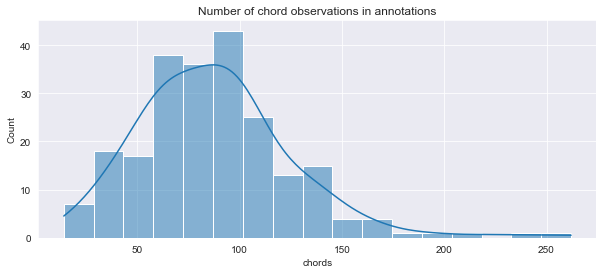

In [22]:

plot_histogram(annotation_stats._no_observations["values"],
    DESCRIPTION, title=f"Number of {NAMESPACE} observations in annotations")

<AxesSubplot:title={'center':'Number of unique chord classes in annotations'}, xlabel='chords', ylabel='Count'>

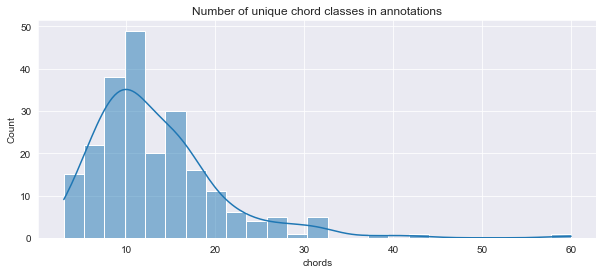

In [23]:

plot_histogram(annotation_stats._no_observations_uniq["values"],
    DESCRIPTION, title=f"Number of unique {NAMESPACE} classes in annotations")

#### Observation values

##### [Observation values] all, with no preprocessing

In [24]:
FIRST_N = 20

# Occurrences of classes accumulated across the whole dataset: as if the dataset
# is a unique annotation (e.g. a very long chord progression)
annotation_stats._observation_cnt_all_abs.most_common(FIRST_N)

[('A', 1839),
 ('G', 1689),
 ('D', 1568),
 ('C', 1151),
 ('E', 1141),
 ('F', 598),
 ('N', 574),
 ('B', 532),
 ('A:min', 512),
 ('E:min', 448),
 ('Bb', 412),
 ('B:min', 361),
 ('F#:min', 314),
 ('D:min', 274),
 ('C:min', 252),
 ('Eb', 251),
 ('Ab', 235),
 ('F:min', 217),
 ('D/5', 206),
 ('G:7', 201)]

In [25]:
# Relative occurrences of classes, first normalised per annotation, then aggregated
annotation_stats._observation_cnt_all_rel.most_common(FIRST_N)

[('A', 0.09798162392356086),
 ('G', 0.0852635138812669),
 ('D', 0.0795699235918226),
 ('E', 0.06915777341893968),
 ('C', 0.06599456730893145),
 ('N', 0.03448283375889302),
 ('B', 0.03155382806000581),
 ('F', 0.0291760362263225),
 ('A:min', 0.02500342335962539),
 ('Bb', 0.02252702342462681),
 ('E:min', 0.021989900520533578),
 ('B:min', 0.018795597157297728),
 ('F#:min', 0.018361795008196787),
 ('G:7', 0.013307276329037835),
 ('D:min', 0.01299705051271006),
 ('D:7', 0.012194912215772168),
 ('C#:min', 0.010983516580728615),
 ('F#', 0.01092735625836903),
 ('Eb', 0.010412948925679682),
 ('Ab', 0.009984482014910362)]

<AxesSubplot:title={'center':'Relative occurrences of chord classes per annotation'}, xlabel='count', ylabel='chords classes'>

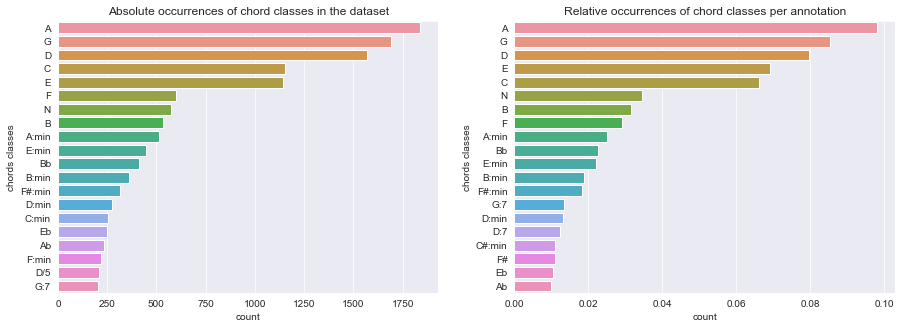

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(annotation_stats._observation_cnt_all_abs,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} classes in the dataset", horizontal=True)

plot_counter(annotation_stats._observation_cnt_all_rel,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} classes per annotation", horizontal=True)

##### [Observation values] after removal of consecutively repeated occurrences

In [27]:
annotation_stats._observation_cnt_norep_abs.most_common(FIRST_N)  # Absolute occurrences

[('A', 1697),
 ('G', 1576),
 ('D', 1482),
 ('C', 1107),
 ('E', 1072),
 ('F', 590),
 ('N', 552),
 ('B', 512),
 ('A:min', 490),
 ('E:min', 434),
 ('Bb', 382),
 ('B:min', 357),
 ('F#:min', 299),
 ('D:min', 264),
 ('C:min', 251),
 ('Eb', 247),
 ('Ab', 225),
 ('F:min', 217),
 ('D/5', 206),
 ('G:7', 196)]

In [28]:
annotation_stats._observation_cnt_norep_rel.most_common(FIRST_N)  # Relative occurrences

[('A', 0.09502847768954968),
 ('G', 0.08326467159697759),
 ('D', 0.07892830481099328),
 ('E', 0.06779703051632162),
 ('C', 0.06585006984399136),
 ('N', 0.034596845361198864),
 ('B', 0.031473919048807274),
 ('F', 0.029718318708001037),
 ('A:min', 0.025060543666662615),
 ('E:min', 0.02207819808358042),
 ('Bb', 0.021880925659457828),
 ('B:min', 0.01957194164417563),
 ('F#:min', 0.018398404336206514),
 ('G:7', 0.013237392278112218),
 ('D:min', 0.012659370743746018),
 ('D:7', 0.012144326815171967),
 ('F#', 0.011427133579630412),
 ('C#:min', 0.011054815223137629),
 ('Eb', 0.010541591414092163),
 ('Ab', 0.009883297446512486)]

<AxesSubplot:title={'center':'Relative occurrences of chord classes per annotation (no repetitions)'}, xlabel='count', ylabel='chords classes'>

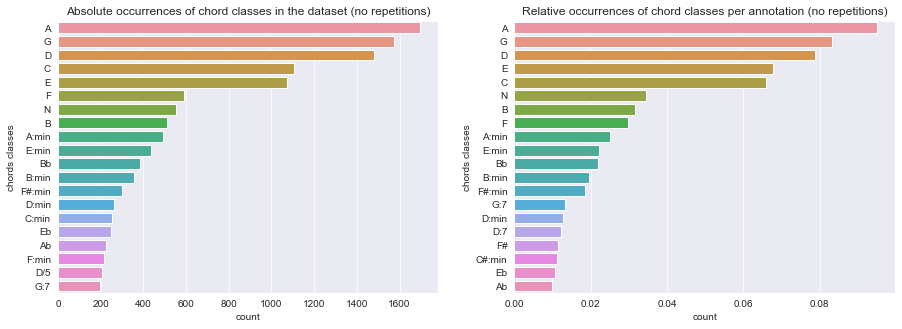

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(annotation_stats._observation_cnt_norep_abs,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} classes in the dataset (no repetitions)", horizontal=True)

plot_counter(annotation_stats._observation_cnt_norep_rel,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} classes per annotation (no repetitions)", horizontal=True)

##### Duration of observations

In [30]:
md(f"The average duration of {NAMESPACE} observations in audio and score JAMS is: {annotation_stats._observation_dur_avgs['audio']['mean']} ± {annotation_stats._observation_dur_avgs['audio']['std']} seconds and {annotation_stats._observation_dur_avgs['score']['mean']} ± {annotation_stats._observation_dur_avgs['score']['std']} beats.")

The average duration of chord observations in audio and score JAMS is: 2.2933759204877524 ± 1.59818607019995 seconds and None ± None beats.

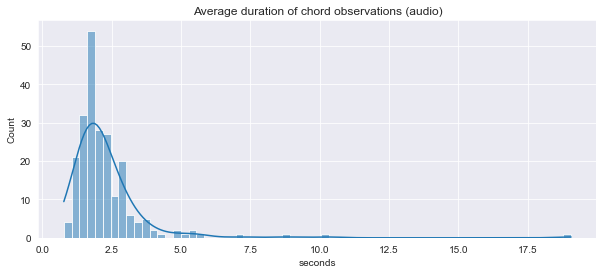

In [31]:
if len(annotation_stats._observation_dur_avgs['audio']["values"]) > 0:
    plot_histogram(annotation_stats._observation_dur_avgs['audio']["values"],
        "seconds", title=f"Average duration of {NAMESPACE} observations (audio)")

In [32]:
if len(annotation_stats._observation_dur_avgs['score']["values"]) > 0:
    plot_histogram(annotation_stats._observation_dur_avgs['score']["values"],
        "beats", title=f"Average duration of {NAMESPACE} observations (score)")

#### Patterns

##### Patterns: 2-gram

In [33]:
# Absolute occurrences of 2-gram observations
create_ngram_df(annotation_stats._observation_cnt_2g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,cnt
0,A,D,456
1,D,G,452
2,E,A,362
3,G,C,329
4,D,A,325
5,A,E,315
6,G,D,284
7,C,G,274
8,B,E,204
9,G,A,196


In [34]:
# Relative occurrences of 2-gram observations
create_ngram_df(annotation_stats._observation_cnt_2g_rel, name=NAMESPACE, first_n=FIRST_N)

,chord_1,chord_2,cnt
0,A,D,0.024067
1,D,G,0.023103
2,E,A,0.022679
3,A,E,0.020833
4,G,C,0.019365
5,D,A,0.018376
6,C,G,0.016451
7,G,D,0.014624
8,B,E,0.013748
9,G,A,0.009921


<AxesSubplot:title={'center':'Relative occurrences of chord 2-grams per annotation'}, xlabel='count', ylabel='chords 2-grams'>

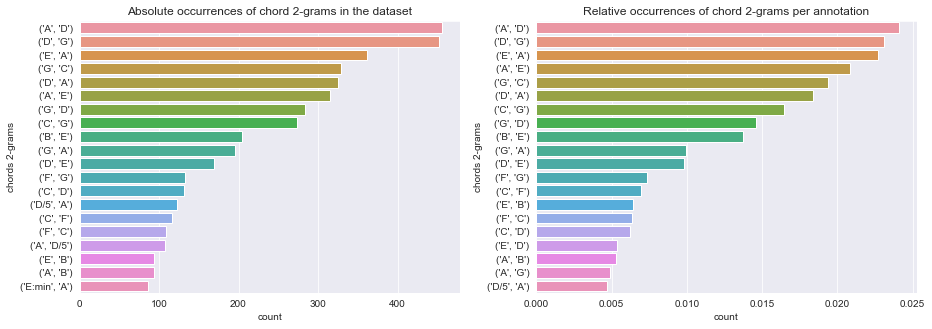

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(annotation_stats._observation_cnt_2g_abs,
    f"{DESCRIPTION} 2-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 2-grams in the dataset", horizontal=True)

plot_counter(annotation_stats._observation_cnt_2g_rel,
    f"{DESCRIPTION} 2-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 2-grams per annotation", horizontal=True)

##### Patterns: 3-gram

In [36]:
# Absolute occurrences of 3-gram observations
create_ngram_df(annotation_stats._observation_cnt_3g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,chord_3,cnt
0,A,D,A,166
1,D,G,D,155
2,G,D,G,150
3,E,A,E,133
4,D,A,D,121
5,G,C,G,118
6,A,E,A,116
7,C,G,C,105
8,E,A,D,102
9,G,A,D,94


In [37]:
# Relative occurrences of 3-gram observations
create_ngram_df(annotation_stats._observation_cnt_3g_rel, name=NAMESPACE, first_n=FIRST_N)

,chord_1,chord_2,chord_3,cnt
0,A,D,A,0.009442
1,E,A,E,0.008854
2,G,D,G,0.007971
3,G,C,G,0.007852
4,A,E,A,0.007410
5,D,G,D,0.007294
6,C,G,C,0.006636
7,D,A,D,0.006497
8,E,A,D,0.005449
9,D,E,A,0.005413


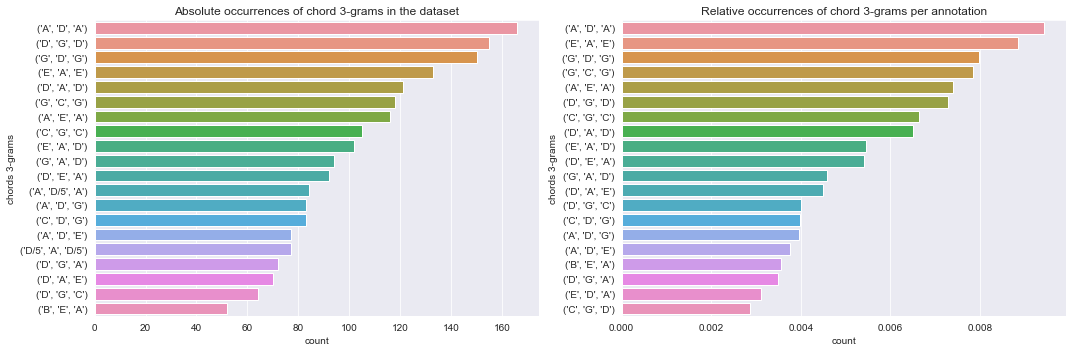

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(annotation_stats._observation_cnt_3g_abs,
    f"{DESCRIPTION} 3-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 3-grams in the dataset", horizontal=True)

plot_counter(annotation_stats._observation_cnt_3g_rel,
    f"{DESCRIPTION} 3-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 3-grams per annotation", horizontal=True)

plt.tight_layout()

##### Patterns: 4-grams

In [39]:
# Absolute occurrences of 4-gram observations
create_ngram_df(annotation_stats._observation_cnt_4g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,chord_3,chord_4,cnt
0,D,G,D,G,122
1,D,A,D,A,90
2,G,D,G,D,89
3,A,D,A,D,81
4,A,D/5,A,D/5,76
5,A,E,A,E,68
6,G,C,G,C,65
7,C,G,C,G,64
8,A,D,E,A,64
9,E,A,E,A,62


In [40]:
# Relative occurrences of 4-gram observations
create_ngram_df(annotation_stats._observation_cnt_4g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,chord_3,chord_4,cnt
0,D,G,D,G,122
1,D,A,D,A,90
2,G,D,G,D,89
3,A,D,A,D,81
4,A,D/5,A,D/5,76
5,A,E,A,E,68
6,G,C,G,C,65
7,C,G,C,G,64
8,A,D,E,A,64
9,E,A,E,A,62


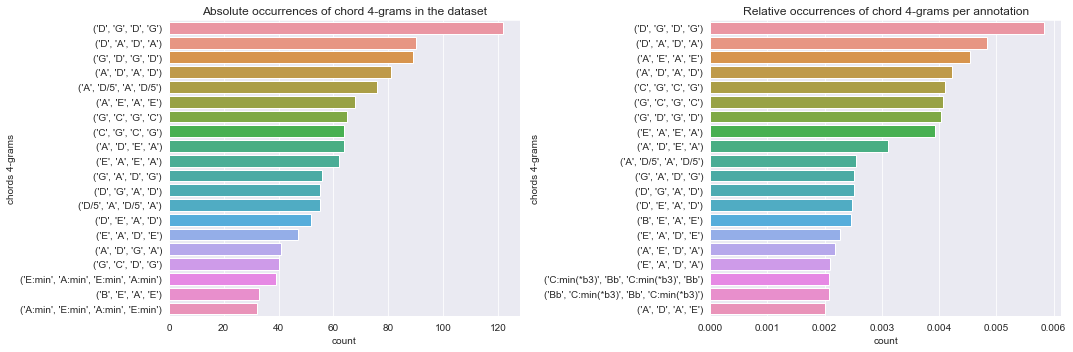

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(annotation_stats._observation_cnt_4g_abs,
    f"{DESCRIPTION} 4-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 4-grams in the dataset", horizontal=True)

plot_counter(annotation_stats._observation_cnt_4g_rel,
    f"{DESCRIPTION} 4-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 4-grams per annotation", horizontal=True)

plt.tight_layout()